### Reference
- https://medium.com/@neotheicebird/webcam-based-image-processing-in-ipython-notebooks-47c75a022514

In [2]:
%matplotlib inline

import numpy as np
import os
import uuid
import cv2
import matplotlib.pyplot as plt
import signal
from IPython import display

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras.models import load_model

In [4]:
cascade_path = 'backend/.fuskar-cache/cache/haarcascade_frontalface_alt2.xml'
model_path = 'backend/.fuskar-cache/cache/facenet_keras.h5'
model = load_model(model_path)
print("Loaded model")

Loaded model


In [5]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [6]:
def calc_embs(imgs, margin, batch_size):
    aligned_images = prewhiten(imgs)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [7]:
class FaceDemo(object):
    def __init__(self, cascade_path, train_dir):
        self.vc = None
        self.cascade = cv2.CascadeClassifier(cascade_path)
        self.margin = 10
        self.batch_size = 1
        self.n_img_per_person = 10
        self.is_interrupted = False
        self.data = {}
        self.le = None
        self.frames = None
        self.clf = None
        self.train_dir = train_dir
        
    def _signal_handler(self, signal, frame):
        self.is_interrupted = True
        
    def capture_images(self, name='Unknown'):
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        imgs = []
        frames = []
        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        while is_capturing:
            is_capturing, frame = vc.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            if len(faces) == 1:
                face = faces[0]
                (x, y, w, h) = face
                left = x - self.margin // 2
                right = x + w + self.margin // 2
                bottom = y - self.margin // 2
                top = y + h + self.margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                imgs.append(img)
                frames.append(frame)
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)
                plt.imshow(frame)
                plt.title('{}/{}'.format(len(imgs), self.n_img_per_person))
                plt.xticks([])
                plt.yticks([])
                display.clear_output(wait=True)
                if not os.path.exists(self.train_dir):
                    os.mkdir(self.train_dir)
                if len(imgs) == self.n_img_per_person:
                    vc.release()
                    for count in range(len(imgs)):
                        if not os.path.exists(self.train_dir + f"{name}/" ):
                            os.mkdir(self.train_dir + f"{name}/")
                        path = self.train_dir + f"{name}/" + f"frame{count}.png"
                        cv2.imwrite(path, frames[count])
                        print(f"Saving image to {path}")
                    self.data[name] = np.array(imgs)
                    break
                try:
                    plt.pause(0.1)
                except Exception:
                    pass
                if self.is_interrupted:
                    vc.release()
                    break
            else:
                print("None or multiple faces in view")

                
    def train(self):
        labels = []
        embs = []
#         names = self.data.keys()
#         for label in os.listdir(self.train_dir):
#             imgs = list()
#             for image in os.listdir(self.train_dir + f"{label}/"):
#                 im_arr = cv2.imread(self.train_dir + f"{label}/{image}")
#                 imgs.append(im_arr)
#             embs = calc_embs(np.array(imgs), self.margin, self.batch_size)
#             labels.extend([label] * len(embs_))
#             embs.append(embs_)
        for name, imgs in self.data.items():
            embs_ = calc_embs(imgs, self.margin, self.batch_size)    
            labels.extend([name] * len(embs_))
            embs.append(embs_)
        embs = np.concatenate(embs)
        le = LabelEncoder().fit(labels)
        y = le.transform(labels)
        clf = SVC(kernel='linear', probability=True).fit(embs, y)
        
        self.le = le
        self.clf = clf
        
    def infer(self):
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        while is_capturing:
            is_capturing, frame = vc.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            pred = None
            if len(faces) != 0:
                face = faces[0]
                (x, y, w, h) = face
                left = x - self.margin // 2
                right = x + w + self.margin // 2
                bottom = y - self.margin // 2
                top = y + h + self.margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                embs = calc_embs(img[np.newaxis], self.margin, 1)
                pred = self.le.inverse_transform(self.clf.predict(embs))
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)
            plt.imshow(frame)
            plt.title(pred)
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            try:
                plt.pause(0.1)
            except Exception:
                pass
            if self.is_interrupted:
                vc.release()
                break

In [8]:
f = FaceDemo(cascade_path, 'backend/test-images/')

Saving image to backend/test-images/hex/frame0.png
Saving image to backend/test-images/hex/frame1.png
Saving image to backend/test-images/hex/frame2.png
Saving image to backend/test-images/hex/frame3.png
Saving image to backend/test-images/hex/frame4.png
Saving image to backend/test-images/hex/frame5.png
Saving image to backend/test-images/hex/frame6.png
Saving image to backend/test-images/hex/frame7.png
Saving image to backend/test-images/hex/frame8.png
Saving image to backend/test-images/hex/frame9.png


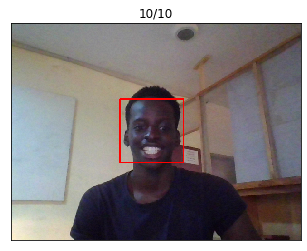

In [10]:
# Train with two or more people
f.capture_images('hex')

In [11]:
f.train()

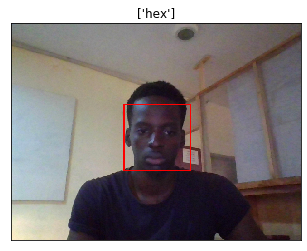

In [12]:
f.infer()
# print(f.data.keys())